#### Imports

In [396]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple
plt.rcParams['figure.figsize'] = [15, 8]

In [2]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import functools
def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

In [5]:
base_dir = "/home/owner/blob/data/data_mining/dblp/csv/"
neo_dir = "/home/owner/blob/data/data_mining/dblp/csv_for_neo/"

### Nodes

In [6]:
publications = pd.read_csv(base_dir + "publications.csv")
print(publications.columns)
publications.head(n=2)

Index(['key', 'type', 'title', 'year'], dtype='object')


,key,type,title,year
0,books/acm/0082477,book,The no-nonsense guide to computing careers.,1992
1,books/acm/Kim95,book,Modern Database Systems: The Object Model Inte...,1995


In [10]:
pub_year_dict = seq(publications[['key','year']]).to_dict()

In [11]:
pub_year_dict['books/acm/Kim95']

1995

In [12]:
persons = pd.read_csv(base_dir + "persons.csv").drop_duplicates(subset="key").dropna()
print(persons.columns)
persons.head()


Index(['key', 'name'], dtype='object')


,key,name
0,johann sebastian rudolph_pers,Johann Sebastian Rudolph
1,anau mesui_pers,Anau Mesui
2,maseka lesaoana_pers,Maseka Lesaoana
3,niran adetoro_pers,Niran Adetoro
4,yinka oyerinde_pers,Yinka Oyerinde


### Edges

In [13]:
authored = pd.read_csv(base_dir + "authored.csv")
# authored['year'] = authored['publication_key'].apply(lambda x: pub_year_dict[x])
print(authored.columns)
authored.head()

Index(['author_name', 'publication_key'], dtype='object')


,author_name,publication_key
0,marc rettig_pers,books/acm/0082477
1,won kim 0001_pers,books/acm/Kim95
2,jurgen annevelink_pers,books/acm/kim95/AnnevelinkACFHK95
3,rafiul ahad_pers,books/acm/kim95/AnnevelinkACFHK95
4,amelia carlson_pers,books/acm/kim95/AnnevelinkACFHK95


# Coauthorship with year graph creation

In [14]:
def to_coauthorship_tuples(arr):
    return ((arr[i],arr[j]) for i in range(0,arr.size() -1) for j in range(i+1, arr.size()))

In [15]:
grouped = seq(authored).group_by(lambda x :x[1])\
.filter(lambda x: len(x[1]) > 1)

In [16]:
coauthorships = grouped.flat_map(
    lambda x: seq(to_coauthorship_tuples(seq(x[1]).map(lambda author_book:author_book[0])))\
    .map(lambda authors: (authors[0],authors[1],pub_year_dict[x[0]])))\
.count_by_value() \
.map(lambda x: (x[0][0],x[0][1],x[0][2],x[1])).to_pandas(columns= ['a_key','b_key','year','count'])

In [18]:
coauthorships.head()

,a_key,b_key,year,count
0,jurgen annevelink_pers,rafiul ahad_pers,1995,1
1,jurgen annevelink_pers,amelia carlson_pers,1995,1
2,jurgen annevelink_pers,daniel h. fishman_pers,1995,1
3,jurgen annevelink_pers,michael l. heytens_pers,1995,1
4,jurgen annevelink_pers,william kent_pers,1995,1


In [19]:
co = seq(coauthorships).map(lambda x: (*tuple(sorted((x[0],x[1]))),x[2],x[3]))\
    .to_pandas(columns= ['a_key','b_key','year','count'])\
    .groupby(['a_key','b_key','year'],as_index=False,axis=0).sum()

In [20]:
len(co)

17769128

In [21]:
co.to_csv(base_dir + "/coauthorships_by_year.csv", index=False,header=False)

### Read

In [400]:
coauthorships = pd.read_csv(base_dir + "/coauthorships_by_year.csv",header=None,names= ['a_key','b_key','year','count'])
coauthorships['year'] = coauthorships.year.apply(int)

In [401]:
coauthorships.head(n=1)

,a_key,b_key,year,count
0,(david) jing dai_pers,gengen he_pers,2017,1


In [402]:
count_by_year = coauthorships[['year','count']].groupby('year',as_index=False).sum()
count_by_year

,year,count
0,1938,1
1,1940,2
2,1942,1
3,1945,2
4,1946,5
...,...,...
74,2016,1810930
75,2017,2009951
76,2018,2344796
77,2019,1849436


Text(0.5, 1.0, 'Coauthorships per year')

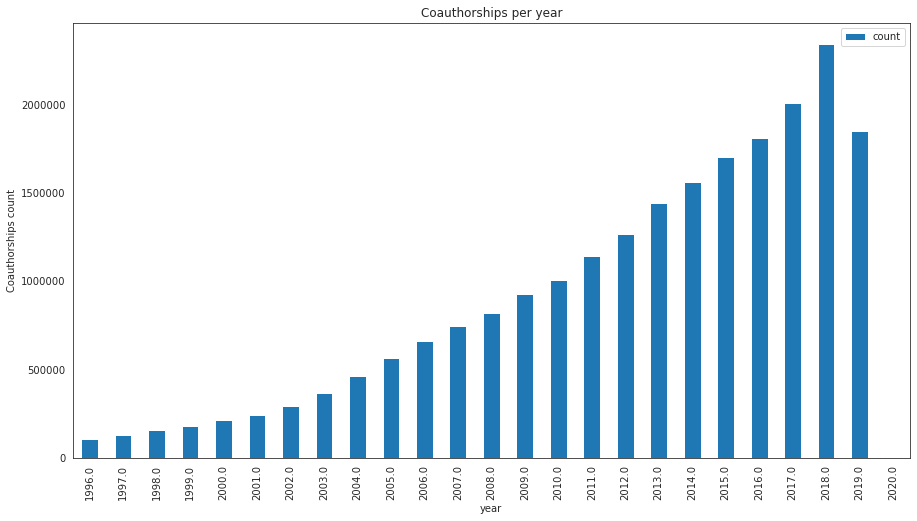

In [405]:
df = count_by_year.where(count_by_year.year > 1995).dropna()

p = df.plot(x='year',y=['count'],kind='bar')
p.set_ylabel('Coauthorships count')
p.set_title('Coauthorships per year')

In [406]:
df['cumsum'] = df['count'].cumsum()
max_sum = df['cumsum'].max()
df['cumperc'] = df['cumsum'].apply(lambda x: x/max_sum)

Text(0.5, 1.0, 'Coauthorships per year')

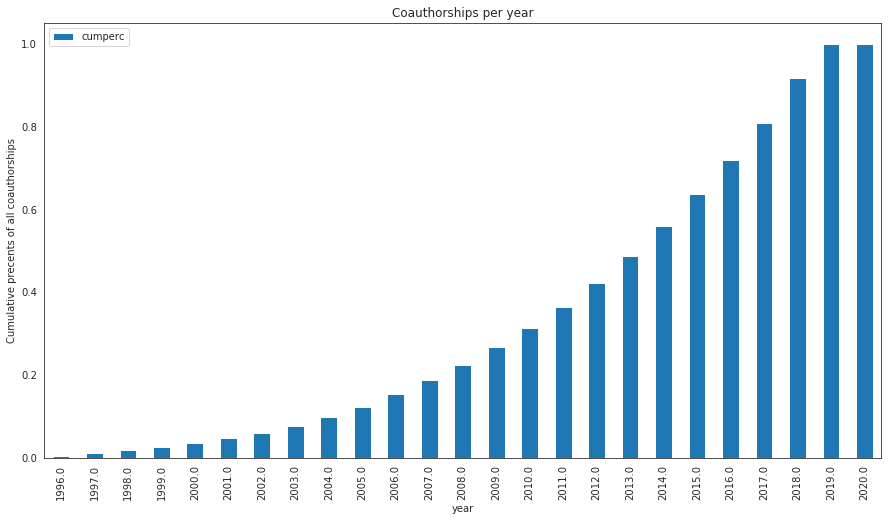

In [411]:
p = df.plot(x='year',y=['cumperc'],kind='bar')
p.set_ylabel('Cumulative precents of all coauthorships')
p.set_title('Coauthorships per year')

In [22]:
df[['year','count','cumperc']]

,year,count,cumperc
54,1996.0,108061.0,0.004909
55,1997.0,128377.0,0.010742
56,1998.0,158905.0,0.017961
57,1999.0,179678.0,0.026124
58,2000.0,210506.0,0.035688
59,2001.0,240702.0,0.046623
60,2002.0,295091.0,0.060030
61,2003.0,368627.0,0.076777
62,2004.0,464014.0,0.097858
63,2005.0,565133.0,0.123533


We will later split train/test at lte 2015

## Inserting

In [29]:
chunk_nb = int(len(coauthorships) /10000)
chunk_nb

1776

In [14]:
from py2neo import Graph
graph = Graph("bolt://127.0.0.1:7687",auth=("neo4j", "admin"))

In [32]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(coauthorships,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'a':x[0],'b':x[1],'year': x[2],'cnt':x[3]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
match  (a:person{key:e.a}) with a, e
match (b:person{key:e.b}) with a,b,e
merge(a)-[:COAUTHORS_IN_YEAR{count: e.cnt, year: e.year}]->(b)
return count(*)
""",entries=entries)
    tx.commit()

100%|██████████| 1776/1776 [32:57<00:00,  1.09it/s]


# Splitting by year into Early /late

In [10]:
split = 2016

In [11]:
coauthorships_early =  coauthorships.where(coauthorships.year <= split).dropna()
coauthorships_late=  coauthorships.where(coauthorships.year > split).dropna()

### Early

In [49]:
chunk_nb = int(len(coauthorships_early) /10000)
chunk_nb

1297

In [50]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(coauthorships_early,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'a':x[0],'b':x[1],'year': x[2],'cnt':x[3]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
match  (a:person{key:e.a}) with a, e
match (b:person{key:e.b}) with a,b,e
merge(a)-[:COAUTHORS_EARLY{count: e.cnt, year: e.year}]->(b)
return count(*)
""",entries=entries)
    tx.commit()

100%|██████████| 1297/1297 [30:00<00:00,  1.04it/s]   


### Late

In [12]:
chunk_nb = int(len(coauthorships_late) /10000)
chunk_nb

479

In [15]:
import tqdm
for i,chunk in tqdm.tqdm(enumerate(np.array_split(coauthorships_late,chunk_nb)),total=chunk_nb):
    entries = seq(chunk).map(lambda x : {'a':x[0],'b':x[1],'year': x[2],'cnt':x[3]}).to_list()
    tx= graph.begin()
    tx.run("""
unwind {entries} as e
match  (a:person{key:e.a}) with a, e
match (b:person{key:e.b}) with a,b,e
merge(a)-[:COAUTHORS_LATE{count: e.cnt, year: e.year}]->(b)
return count(*)
""",entries=entries)
    tx.commit()

100%|██████████| 479/479 [10:57<00:00,  1.01s/it]


# Creating Test/Train

In [7]:
missing_link_dir = base_dir + "missing_link/"

In [8]:
from py2neo import Graph
graph = Graph("bolt://127.0.0.1:7687",auth=("neo4j", "admin"))

## Test

In [9]:
# Find positive examples

# train_existing_links = graph.run("""
# MATCH (author:person)-[:COAUTHORS_EARLY]->(other:person)
# RETURN id(author) AS node1, id(other) AS node2, 1 AS label
# """).to_data_frame()
# train_existing_links.to_csv(missing_link_dir + "train_existing_links.csv",index=False)

In [102]:
train_existing_links = pd.read_csv(missing_link_dir + "train_existing_links.csv")

In [103]:
train_size  = 80 *1000
train_existing_links = train_existing_links.sample(n= train_size)

In [25]:
## Find negative examples

# train_missing_links = graph.run("""
# MATCH (author:person)
# WHERE (author)-[:COAUTHORS_EARLY]-()
# MATCH (author)-[:COAUTHORS_EARLY*2..3]-(other)
# WHERE not((author)-[:COAUTHORS_EARLY]-(other))
# RETURN id(author) AS node1, id(other) AS node2, 0 AS label  limit {}
# """.format(int(train_size * 50) )).to_data_frame()

# # Remove duplicates
# train_missing_links = train_missing_links.drop_duplicates()
# train_missing_links.to_csv(missing_link_dir + "train_missing_links.csv",index=False)

Problem - left nodes have 9 distinct ids

In [104]:
train_missing_links = pd.read_csv(missing_link_dir + "train_missing_links.csv")

In [105]:
train_missing_links = train_missing_links.sample(n= train_size)

In [106]:
# Create DataFrame from positive and negative examples
training_df = train_missing_links.append(
    train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [107]:
training_df.to_csv(missing_link_dir + "train_base.csv", index=False)

## Train

In [52]:
# Find positive examples
# test_existing_links = graph.run("""
# MATCH (author:person)-[:COAUTHORS_LATE]->(other:person)
# RETURN id(author) AS node1, id(other) AS node2, 1 AS label
# """).to_data_frame()
# test_existing_links.to_csv(missing_link_dir + "test_existing_links.csv",index=False)

In [50]:
test_existing_links = pd.read_csv(missing_link_dir + "test_existing_links.csv")

In [51]:
len(test_existing_links)

4798116

In [66]:
test_size = 20 * 1000
test_existing_links = test_existing_links.drop_duplicates()
len(test_existing_links)

19988

In [57]:
# Find negative examples
test_missing_links = graph.run("""
MATCH (author:person)
WHERE (author)-[:COAUTHORS_LATE]-()
MATCH (author)-[:COAUTHORS_LATE*2..3]-(other)
WHERE not((author)-[:COAUTHORS_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label limit {}
""".format(int(test_size * 100))).to_data_frame()

In [67]:
len(test_missing_links.drop_duplicates())

20000

In [69]:
# Remove duplicates 
test_missing_links = test_missing_links.drop_duplicates()# Down sample negative examples
test_missing_links = test_missing_links.sample(n=len(test_existing_links))# Create DataFrame from positive and negative examples

In [70]:
len(test_missing_links.drop_duplicates())

19988

In [71]:
test_df = test_missing_links.append(
    test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

In [73]:
test_df.to_csv(missing_link_dir + "test_base.csv", index=False)

## Feature engineering

In [77]:
def apply_graphy_features(data:pd.DataFrame, rel_type:str) -> pd.DataFrame:
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(
               p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(
               p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": pair[0], "node2": pair[1]}  
             for pair in data[["node1", "node2"]].values.tolist()]
    params = {"pairs": pairs, "relType": rel_type}
    
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [108]:
training_df = apply_graphy_features(training_df, "COAUTHORS_EARLY") 

In [109]:
training_df.to_csv(missing_link_dir + "training_with_features.csv", index=False)

In [80]:
test_df = apply_graphy_features(test_df, "COAUTHORS_IN_YEAR")
test_df.to_csv(missing_link_dir + "test_with_features.csv", index=False)

In [9]:
test_df = pd.read_csv(missing_link_dir + "test_with_features.csv")
training_df = pd.read_csv(missing_link_dir + "training_with_features.csv")

# Classification

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer


In [230]:
def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    precision = precision_score(actual, predictions)
    recall = recall_score(actual, predictions)
    f1 = f1_score(actual,predictions)
    
    metrics = ["accuracy", "precision", "recall","f1"]
    values = [accuracy, precision, recall,f1]    
    return pd.DataFrame(data={'metric': metrics, 'value': values})

def feature_importance(columns, classifier):        
    features = list(zip(columns, classifier.feature_importances_))
    sorted_features = sorted(features, key = lambda x: x[1]*-1)
    
    keys = [value[0] for value in sorted_features]
    values = [value[1] for value in sorted_features]
    return pd.DataFrame(data={'feature': keys, 'value': values})

In [283]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [2,4,15,30,None],
    'n_estimators': [10,40,100],
    'random_state': [0]
}




rf = RandomForestClassifier()
# not working
grid_search = GridSearchCV(
    estimator = rf,
    param_grid = param_grid,
    scoring = make_scorer(accuracy_score),
    cv=2 ,
    n_jobs = -1,
    verbose = 2)

In [284]:
columns = ["cn", "pa", "tn"]
grid_search.fit(training_df[columns], training_df["label"])

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   18.7s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [285]:
grid_search.best_score_

0.98503813451082

In [286]:
grid_search.best_params_

{'max_depth': 15, 'n_estimators': 100, 'random_state': 0}

In [287]:
rf = grid_search.best_estimator_

In [288]:
rf.score(test_df[columns],test_df["label"])

0.9162497498499099

In [289]:
predictions = rf.predict(test_df[columns])
y_test = test_df["label"]
display(evaluate_model(predictions, y_test))
print(classification_report(y_test,predictions))

,metric,value
0,accuracy,0.916250
1,precision,0.862812
2,recall,0.989894
3,f1,0.921994


              precision    recall  f1-score   support

           0       0.99      0.84      0.91     19988
           1       0.86      0.99      0.92     19988

    accuracy                           0.92     39976
   macro avg       0.93      0.92      0.92     39976
weighted avg       0.93      0.92      0.92     39976



In [290]:
feature_importance(columns,rf)

,feature,value
0,cn,0.771922
1,tn,0.158726
2,pa,0.069352


### By hand

In [415]:
columns = ["cn", "pa", "tn"]
rf_by_hand = RandomForestClassifier(n_estimators=40, max_depth=2)

X = training_df[columns]
y = training_df["label"]
rf_by_hand.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [336]:
predictions = rf_by_hand.predict(test_df[columns])
y_test = test_df["label"]
display(evaluate_model(predictions, y_test))
display(feature_importance(columns,rf_by_hand))
print(classification_report(y_test,predictions))

,metric,value
0,accuracy,0.970107
1,precision,0.959419
2,recall,0.981739
3,f1,0.970451


,feature,value
0,cn,0.530007
1,tn,0.398644
2,pa,0.071349


              precision    recall  f1-score   support

           0       0.98      0.96      0.97     19988
           1       0.96      0.98      0.97     19988

    accuracy                           0.97     39976
   macro avg       0.97      0.97      0.97     39976
weighted avg       0.97      0.97      0.97     39976



In [281]:
rf_by_hand.score(test_df[columns],test_df["label"])

0.970282169301581

# Adding triangle count / clustering coefficient

In [14]:
# done

# graph.run(
# """
# CALL algo.triangleCount('person', 'COAUTHORS_EARLY', { 
#   write:true,
#   writeProperty:'trianglesTrain', 
#   clusteringCoefficientProperty:'coefficientTrain'});
# """)

In [18]:
# test:
graph.run(
"""
CALL algo.triangleCount('person', 'COAUTHORS_IN_YEAR', { 
  write:true,
  writeProperty:'trianglesTest', 
  clusteringCoefficientProperty:'coefficientTest'});
""")

In [21]:
def apply_triangles_features(data,triangles_prop,coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    apoc.coll.min([p1[$triangles], p2[$triangles]]) AS minTriangles,
    apoc.coll.max([p1[$triangles], p2[$triangles]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficient], p2[$coefficient]]) AS minCoeff,
    apoc.coll.max([p1[$coefficient], p2[$coefficient]]) AS maxCoeff
    """
    
    pairs = [{"node1": pair[0], "node2": pair[1]}  for pair in data[["node1", "node2"]].values.tolist()]
    params = {"pairs": pairs,
              "triangles": triangles_prop,
              "coefficient": coefficient_prop}
    
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [22]:
training_df = apply_triangles_features(training_df, 
  "trianglesTrain", "coefficientTrain")

In [23]:
training_df.to_csv(missing_link_dir + "training_with_coef_and_features.csv", index=False)

In [24]:
test_df = apply_triangles_features(test_df, 
  "trianglesTest", "coefficientTest")

In [25]:
test_df.to_csv(missing_link_dir + "test_with_coef_and_features.csv", index=False)

In [33]:
test_df = pd.read_csv(missing_link_dir + "test_with_coef_and_features.csv")
training_df = pd.read_csv(missing_link_dir + "training_with_coef_and_features.csv")

# Evaluating with clustering coeff

In [329]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=40, max_depth=3, 
                                    random_state=0)

columns = [
    "cn", "pa", "tn", 
    "minTriangles", "maxTriangles", "minCoeff", "maxCoeff"]
X = training_df[columns]
y = training_df["label"]
rf.fit(X, y)
predictions = rf.predict(test_df[columns])
y_test = test_df["label"]
display(evaluate_model(predictions, y_test))

,metric,value
0,accuracy,0.934686
1,precision,0.890161
2,recall,0.991745
3,f1,0.938211


In [294]:
display(feature_importance(columns, rf))

,feature,value
0,cn,0.516031
1,maxTriangles,0.149921
2,minCoeff,0.127040
3,tn,0.092862
4,maxCoeff,0.078566
5,minTriangles,0.017868
6,pa,0.017711


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [2,4,6,10],
    'max_features': [2, 4,6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [10,20,30,40,50]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
columns = [
    "cn", "pa", "tn", 
    "minTriangles", "maxTriangles", "minCoeff", "maxCoeff"]
grid_search.fit(training_df[columns], training_df["label"])

In [295]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

/home/owner/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  3.2min finished


0.9976219148755002
{'max_depth': 6, 'n_estimators': 200}


In [296]:
best_rf = clf.best_estimator_


In [384]:
columns = [
    "cn", "pa", "tn", 
    "minTriangles", "maxTriangles", "minCoeff", "maxCoeff"]
# best_rf = xgb.XGBClassifier(n_estimators=80,max_depth=3)
best_rf = RandomForestClassifier(n_estimators=200,max_depth=3)
best_rf.fit(training_df[columns],training_df["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [385]:
predictions = best_rf.predict(test_df[columns])
y_test = test_df["label"]
print(classification_report(y_test,predictions))
display(evaluate_model(predictions, y_test))
display(feature_importance(columns,best_rf))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     19988
           1       0.94      0.99      0.97     19988

    accuracy                           0.96     39976
   macro avg       0.97      0.96      0.96     39976
weighted avg       0.97      0.96      0.96     39976



,metric,value
0,accuracy,0.964654
1,precision,0.940103
2,recall,0.992546
3,f1,0.965613


,feature,value
0,cn,0.489987
1,minCoeff,0.150797
2,maxTriangles,0.140900
3,tn,0.095948
4,maxCoeff,0.086005
5,pa,0.020361
6,minTriangles,0.016002


In [412]:
# Draw the heatmap with the mask and correct aspect ratio
import seaborn as sns
def show_corr(df:pd.DataFrame):
    corr =np.abs(df[columns + ["label"]].corr())
    sns.set_style('white')
    mask = np.zeros_like(corr , dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=0.0,vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

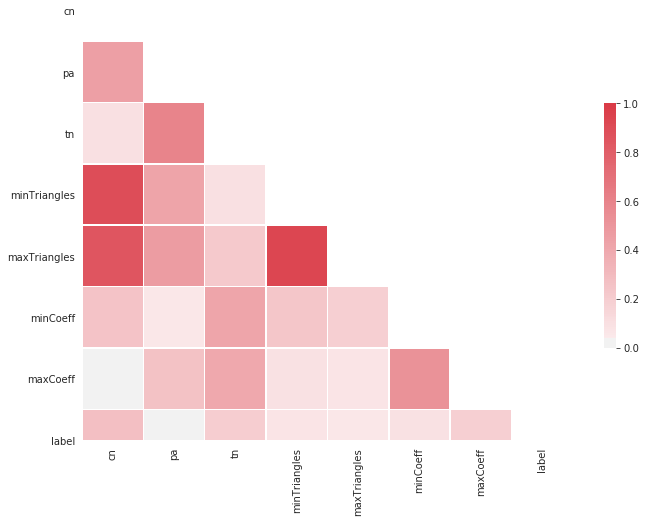

In [413]:
show_corr(training_df)

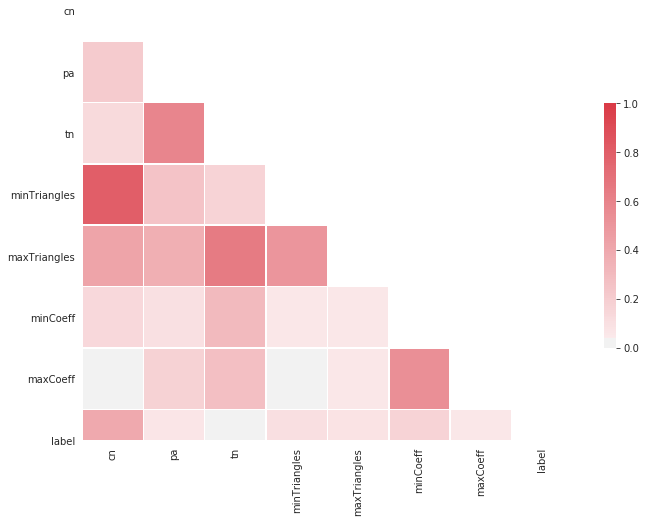

In [414]:
show_corr(test_df)